<img src="images/banner_introRProg.png" align="left" />

<table style="float:right;">
    <tr>
        <td>                      
            <div style="text-align: right"><a href="https://www.research.manchester.ac.uk/portal/mudassar.iqbal.html" target="_blank">Mudassar Iqbal</a></div>
            <div style="text-align: right">Lecturer in Health Data Sciences</div>
            <div style="text-align: right">University of Manchester</div>
         </td>
         <td>
             <img src="images/mudassar_iqbal.png" width="50%" />
         </td>
     </tr>
</table>

# RNA-seq: Exploratory analysis and differential expression
****

#### About this Notebook
This notebook follows the differential expression [RNA-seq workflow](https://f1000research.com/articles/4-1070) and helps you practice some exploratory analysis of example RNA-seq data using different packages in R and Bioconductor.

For help in using this Jupyter notebook please refer to the [Jupyter Notebook User Guide](https://online.manchester.ac.uk/bbcswebdav/orgs/I3116-ADHOC-I3HS-HUB-1/Jupyter%20Notebooks/content/index.html#/)

Level: <code>intermediate</code> 

Duration: Approximately 2-3 hours to complete

<div class="alert alert-block alert-warning"><b>Learning Objectives:</b> 
<br/> At the end of this notebook you will be able to:
    
    
- Investigate how to complete some exploratory RNAseq data analysis 
- Follow the differential expression RNA-seq workflow using DESeq2
- Practice using the following Bioconductor packages:
    - airway
    - tximeta
    - DESeq2
    - vsn
    - apeglm
    - genefilter
    
- Practice using the following R packages: 
    - dplyr
    - ggplot2
    - pheatmap
    - RColorBrewer
    - ggbeeswarm


</div> 

<a id="top"></a>

<b>Table of contents</b><br>

1.0 [About the Data](#data)

2.0 [Workflow ](#workflow)

3.0 [Quantification](#quantification)

4.0 [The DESeqDataSet object, sample information and the design formula](#seqobject)

5.0 [The variance stabilizing transformation and the rlog](#rlog)

6.0 [Sample distances](#sampledistances)

7.0 [Differential expression analysis](#dea)

8.0 [Plotting results](#plotting)

9.0 [Gene clustering](#clustering)

10.0 [Annotating and exporting results](#results)

11.0 [Your Turn](#yourturn)


*****

<a id="data"></a>

## About the Data

We will use RNA-seq data from an experiment wherein airway smooth muscle cells were treated with dexamethasone, a synthetic glucocorticoid steroid with anti-inflammatory effects (Himes et al. 2014). In the experiment, four primary human airway smooth muscle cell lines were treated with 1 micromolar dexamethasone for 18 hours. For each of the four cell lines, we have a treated and an untreated sample. For more description of the experiment see the PubMed entry 24926665 and for raw data see the GEO entry GSE52778.

For full details on how to prepare input files to DE analysis tools/packges, see section 2.1 https://bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html

If you would like to dig into analysis of raw RNA-seq data, transcript and gene-based quantifications, below are the tutorials for two popular methods, Salmon and Kallisto:

https://combine-lab.github.io/salmon/getting_started/

https://pachterlab.github.io/kallisto/starting

Here, we will work with the data which is already pre-processed. We will just load the *airway* package which include the data we need (Salmon output).

In [57]:
library("airway")

We will use R function ‘system.file’ to find out where ‘airway’ package has stored the data.

In [58]:
dir <- system.file("extdata", package="airway", mustWork=TRUE)
dir
list.files(dir)

[1] "/Library/Frameworks/R.framework/Versions/3.6/Resources/library/airway/extdata"

[1] "GSE52778_series_matrix.txt"        "Homo_sapiens.GRCh37.75_subset.gtf"
 [3] "quants"                            "sample_table.csv"                 
 [5] "SraRunInfo_SRP033351.csv"          "SRR1039508_subset.bam"            
 [7] "SRR1039509_subset.bam"             "SRR1039512_subset.bam"            
 [9] "SRR1039513_subset.bam"             "SRR1039516_subset.bam"            
[11] "SRR1039517_subset.bam"             "SRR1039520_subset.bam"            
[13] "SRR1039521_subset.bam"


*****
[back to the top](#top)

<a id="workflow"></a>

## About the workflow

<img src="images/rnaseq-workflow.png"/>

*****
[back to the top](#top)

<a href id="quantification"></a>


## Quantification

Here, we will not be using all the alighnment (bam) files for quantifiaction. If you are interested in performing quantifiaction yourself, you can follow short tutorial [here](https://bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#quantifying-with-salmon) (section 2.2) for airway data or follow more detailed tutorials for [Salmon](https://combine-lab.github.io/salmon/getting_started/) and [Kallisto](https://pachterlab.github.io/kallisto/starting). 

For now, we will work with existing Salmon output in 'quants' directory using ‘tximeta’ package.



In [20]:
list.files(file.path(dir, "quants"))
# Only two samples 

[1] "SRR1039508" "SRR1039509"

Typically, we have a table with detailed information for each of our samples that links samples to the associated FASTQ and Salmon directories. For your own project, you might create such a comma-separated value (CSV) file using a text editor or spreadsheet software such as Excel.

We load such a CSV file with read.csv:

In [60]:
csvfile <- file.path(dir, "sample_table.csv")
coldata <- read.csv(csvfile, row.names=1, stringsAsFactors=FALSE)
coldata

,SampleName,cell,dex,albut,Run,avgLength,Experiment,Sample,BioSample
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
SRR1039508,GSM1275862,N61311,untrt,untrt,SRR1039508,126,SRX384345,SRS508568,SAMN02422669
SRR1039509,GSM1275863,N61311,trt,untrt,SRR1039509,126,SRX384346,SRS508567,SAMN02422675
SRR1039512,GSM1275866,N052611,untrt,untrt,SRR1039512,126,SRX384349,SRS508571,SAMN02422678
SRR1039513,GSM1275867,N052611,trt,untrt,SRR1039513,87,SRX384350,SRS508572,SAMN02422670
SRR1039516,GSM1275870,N080611,untrt,untrt,SRR1039516,120,SRX384353,SRS508575,SAMN02422682
SRR1039517,GSM1275871,N080611,trt,untrt,SRR1039517,126,SRX384354,SRS508576,SAMN02422673
SRR1039520,GSM1275874,N061011,untrt,untrt,SRR1039520,101,SRX384357,SRS508579,SAMN02422683
SRR1039521,GSM1275875,N061011,trt,untrt,SRR1039521,98,SRX384358,SRS508580,SAMN02422677


To demonstrate loading Salmon quantifiation data into R, we will just work with the two samples that are provided in the airway package. We create a column called ‘names’ and a column called ‘files’:

In [61]:
coldata <- coldata[1:2,]
coldata$names <- coldata$Run
coldata$files <- file.path(dir, "quants", coldata$names, "quant.sf.gz")
file.exists(coldata$files)

[1] TRUE TRUE

In [62]:
coldata$file
# quants folder have only two files

[1] "/Library/Frameworks/R.framework/Versions/3.6/Resources/library/airway/extdata/quants/SRR1039508/quant.sf.gz"
[2] "/Library/Frameworks/R.framework/Versions/3.6/Resources/library/airway/extdata/quants/SRR1039509/quant.sf.gz"

**tximeta** package - We will use it to import transcript quantifications from Salmon. Starting with a sample table, it performs many tasks in terms of gathering annotations etc automatically, details can be found here [tximeta](https://bioconductor.org/packages/3.11/bioc/vignettes/tximeta/inst/doc/tximeta.html). This can take few minutes, and will output a SummarizedExperiment object. 

In [63]:
library("tximeta")
se <- tximeta(coldata)
#Creates a summarised experiment

importing quantifications

reading in files with read_tsv

1 
2 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 29 ]

loading existing TxDb created: 2020-10-28 16:25:15

loading existing transcript ranges created: 2020-10-28 16:27:16

fetching genome info for GENCODE



Note: tximeta imports data at the transcript level. You can check the dimension of SummarizedExperiment object 'se' we just created. 

In [26]:
dim(se)
#Transcripts in two samples

[1] 205870      2

This gives us total number of transcripts, we can display few transcript names:

In [64]:
head(rownames(se))

[1] "ENST00000456328.2" "ENST00000450305.2" "ENST00000488147.1"
[4] "ENST00000619216.1" "ENST00000473358.1" "ENST00000469289.1"

Now, we can summarize the transcript-level quantifications to the gene-level (again just for two samples, as en example)



In [65]:
gse1 <- summarizeToGene(se)

loading existing TxDb created: 2020-10-28 16:25:15

obtaining transcript-to-gene mapping from TxDb

loading existing gene ranges created: 2020-10-28 16:30:40

summarizing abundance

summarizing counts

summarizing length



In [29]:
dim(gse1)
# genes in two samples

[1] 58294     2

Display few gene names

In [30]:
head(rownames(gse1))

[1] "ENSG00000000003.14" "ENSG00000000005.5"  "ENSG00000000419.12"
[4] "ENSG00000000457.13" "ENSG00000000460.16" "ENSG00000000938.12"

A new SummarizedExperiment object with gene-level quantifiactions:

In [67]:
gse1

class: RangedSummarizedExperiment 
dim: 58294 2 
metadata(6): tximetaInfo quantInfo ... txomeInfo txdbInfo
assays(3): counts abundance length
rownames(58294): ENSG00000000003.14 ENSG00000000005.5 ...
  ENSG00000285993.1 ENSG00000285994.1
rowData names(1): gene_id
colnames(2): SRR1039508 SRR1039509
colData names(10): SampleName cell ... BioSample names

You can see tximeta is saving you a lot of hassle here!

### Other methods
While the above section described use of Salmon and tximeta, there are many possible inputs to DESeq2, each of which have their own dedicated import functions. The following tools can be used to generate or compile count data for use with DESeq2: tximport (Soneson, Love, and Robinson 2015), tximeta (Love et al. 2020), htseq-count (Anders, Pyl, and Huber 2015), featureCounts (Liao, Smyth, and Shi 2014), summarizeOverlaps (Lawrence et al. 2013).

Import functions and corresponding DESeq2 input function:
----------------------------------------------------------------------

- tximport (tximport, R/Bioconductor) - DESeqDataSetFromTximport

- tximeta (tximeta, R/Bioconductor) - DESeqDataSet

- htseq-count (Python, HTSeq) - DESeqDataSetFromHTSeq
- featureCounts (Rsubread, R/Bioconductor) - DESeqDataSetFromMatrix
- summarizeOverlaps (GenomicAlignments, R/Bioconductor) - DESeqDataSet



#### The SummarizedExperiment 
We can practice some plotting too.

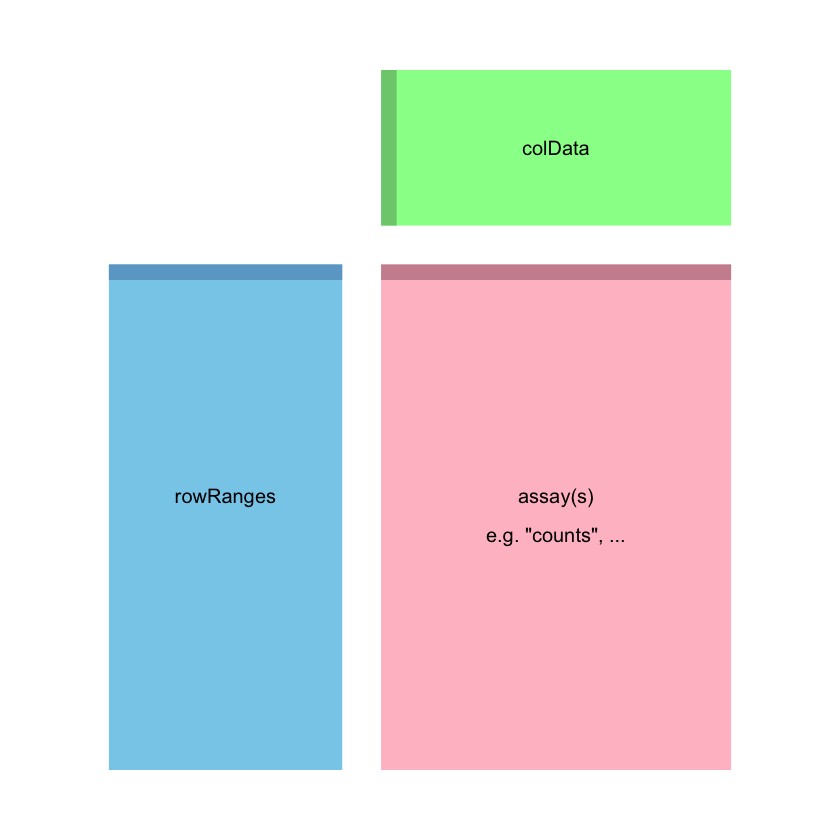

In [32]:
par(mar=c(0,0,0,0))
plot(1,1,xlim=c(0,100),ylim=c(0,100),bty="n",
     type="n",xlab="",ylab="",xaxt="n",yaxt="n")
polygon(c(45,90,90,45),c(5,5,70,70),col="pink",border=NA)
polygon(c(45,90,90,45),c(68,68,70,70),col="pink3",border=NA)
text(67.5,40,"assay(s)")
text(67.5,35,'e.g. "counts", ...')
polygon(c(10,40,40,10),c(5,5,70,70),col="skyblue",border=NA)
polygon(c(10,40,40,10),c(68,68,70,70),col="skyblue3",border=NA)
text(25,40,"rowRanges")
polygon(c(45,90,90,45),c(75,75,95,95),col="palegreen",border=NA)
polygon(c(45,47,47,45),c(75,75,95,95),col="palegreen3",border=NA)
text(67.5,85,"colData")

<img src="images/coldata.png"/>

The assay (pink block) contains the matrix of counts, the rowRanges (blue block) contains information about the genomic ranges and the colData (green block) contains information about the samples. The highlighted line in each block represents the first row (note that the first row of colData lines up with the first column of the assay. i.e., samples).

The SummarizedExperiment container is diagrammed in the Figure above and discussed in the latest Bioconductor paper (Huber et al. 2015). In our case, tximeta has created an object gse with three matrices: “counts” - the estimated fragment counts for each gene and sample, “abundance” - the estimated transcript abundances in TPM, and “length” - the effective gene lengths which include changes in length due to biases as well as due to transcript usage. The names of the assays can be examined with assayNames, and the assays themselves are stored as assays (a list of matrices). The first matrix in the list can be pulled out via assay. The rowRanges for our object is the GRanges of the genes (from the left-most position of all the transcripts to the right-most position of all the transcripts). The component parts of the SummarizedExperiment are accessed with an R function of the same name: assay (or assays), rowRanges and colData.



Now, we will load the full count matrix corresponding to all samples and all data, which is also provided in the airway package, and from here onwards we will continue the analysis with the full data object.

In [68]:
# Now Load the full dataset
data(gse)
gse

class: RangedSummarizedExperiment 
dim: 58294 8 
metadata(6): tximetaInfo quantInfo ... txomeInfo txdbInfo
assays(3): counts abundance length
rownames(58294): ENSG00000000003.14 ENSG00000000005.5 ...
  ENSG00000285993.1 ENSG00000285994.1
rowData names(1): gene_id
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(3): names donor condition

The counts are the first matrix, so we can examine them with just assay:

In [69]:
assayNames(gse)

[1] "counts"    "abundance" "length"

In [76]:
head(assay(gse,1), 3)
# or just 
#head(assay(gse), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003.14,708.164,467.962,900.992,424.368,1188.295,1090.668,805.929,599.337
ENSG00000000005.5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSG00000000419.12,455.000,510.000,604.000,352.000,583.000,773.999,409.999,499.000


We can display total number of counts for each sample

In [36]:
colSums(assay(gse))

SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520 
  21100805   19298584   26145537   15688246   25268618   31891456   19683767 
SRR1039521 
  21813903

The rowRanges, when printed, shows the ranges for the first five and last five genes:

In [37]:
rowRanges(gse)

GRanges object with 58294 ranges and 1 metadata column:
                     seqnames              ranges strand |            gene_id
                        <Rle>           <IRanges>  <Rle> |        <character>
  ENSG00000000003.14     chrX 100627109-100639991      - | ENSG00000000003.14
   ENSG00000000005.5     chrX 100584802-100599885      + |  ENSG00000000005.5
  ENSG00000000419.12    chr20   50934867-50958555      - | ENSG00000000419.12
  ENSG00000000457.13     chr1 169849631-169894267      - | ENSG00000000457.13
  ENSG00000000460.16     chr1 169662007-169854080      + | ENSG00000000460.16
                 ...      ...                 ...    ... .                ...
   ENSG00000285990.1    chr14   19244904-19269380      - |  ENSG00000285990.1
   ENSG00000285991.1     chr6 149817937-149896011      - |  ENSG00000285991.1
   ENSG00000285992.1     chr8   47129262-47132628      + |  ENSG00000285992.1
   ENSG00000285993.1    chr18   46409197-46410645      - |  ENSG00000285993.1
   ENSG0

The rowRanges also contains metadata about the sequences (chromosomes) in the seqinfo slot:

In [38]:
seqinfo(rowRanges(gse))

Seqinfo object with 25 sequences (1 circular) from hg38 genome:
  seqnames seqlengths isCircular genome
  chr1      248956422      FALSE   hg38
  chr2      242193529      FALSE   hg38
  chr3      198295559      FALSE   hg38
  chr4      190214555      FALSE   hg38
  chr5      181538259      FALSE   hg38
  ...             ...        ...    ...
  chr21      46709983      FALSE   hg38
  chr22      50818468      FALSE   hg38
  chrX      156040895      FALSE   hg38
  chrY       57227415      FALSE   hg38
  chrM          16569       TRUE   hg38

The colData for the SummarizedExperiment reflects the data.frame that was provided to the tximeta function for importing the quantification data. Here we can see that there are columns indicating sample names, as well as the donor ID, and the treatment condition (treated with dexamethasone or untreated).

In [39]:
colData(gse)

DataFrame with 8 rows and 3 columns
                names    donor     condition
             <factor> <factor>      <factor>
SRR1039508 SRR1039508   N61311     Untreated
SRR1039509 SRR1039509   N61311 Dexamethasone
SRR1039512 SRR1039512  N052611     Untreated
SRR1039513 SRR1039513  N052611 Dexamethasone
SRR1039516 SRR1039516  N080611     Untreated
SRR1039517 SRR1039517  N080611 Dexamethasone
SRR1039520 SRR1039520  N061011     Untreated
SRR1039521 SRR1039521  N061011 Dexamethasone

There are many methods for DE analysis, here we will show how to use summarizedExperiment object to create the data object used by DESeq2 (Love, Huber, and Anders 2014)..


*****
[back to the top](#top)

<a href id="seqobject"></a>

## The DESeqDataSet object, sample information and the design formula

To work with DESeq2, we will create the custom class called DESeqDataSet. It is built on top of the SummarizedExperiment class, and it is easy to convert SummarizedExperiment objects into DESeqDataSet objects. One of the two main differences is that the assay slot is instead accessed using the counts accessor function, and the DESeqDataSet class enforces that the values in this matrix are non-negative integers. A second difference is that the DESeqDataSet has an associated *design formula*. The experimental design is specified at the beginning of the analysis, as it will inform many of the DESeq2 functions how to treat the samples in the analysis (one exception is the size factor estimation, i.e., the adjustment for differing library sizes, which does not depend on the design formula). The design formula tells which columns in the sample information table (colData) specify the experimental design and how these factors should be used in the analysis.

First, let’s examine the columns of the colData of gse. We can see each of the columns just using the $ directly on the SummarizedExperiment or DESeqDataSet.

In [77]:
gse$donor

[1] N61311  N61311  N052611 N052611 N080611 N080611 N061011 N061011
Levels: N052611 N061011 N080611 N61311

In [78]:
gse$condition

[1] Untreated     Dexamethasone Untreated     Dexamethasone Untreated    
[6] Dexamethasone Untreated     Dexamethasone
Levels: Untreated Dexamethasone

We can rename our variables if we want. Let’s use cell to denote the donor cell line, and dex to denote the treatment condition.

In [79]:
gse$cell <- gse$donor
gse$dex <- gse$condition

We can also change the names of the levels. It is critical when one renames levels to not change the order. Here we will rename “Untreated” as “untrt” and “Dexamethasone” as “trt”:

In [80]:
levels(gse$dex)

[1] "Untreated"     "Dexamethasone"

In [81]:
# when renaming levels, the order must be preserved!
levels(gse$dex) <- c("untrt", "trt")

The simplest design formula for differential expression would be ~condition, where condition is a column in colData(dds) that specifies which of two (or more groups) the samples belong to. For the airway experiment, we will specify ~cell + dex meaning that we want to test for the effect of dexamethasone (dex) controlling for the effect of different cell line (cell).

In the following sections, we will demonstrate the construction of the DESeqDataSet from two starting points:

-from a SummarizedExperiment object

-from a count matrix and a sample information table

For a full example of using the HTSeq Python package for read counting, please see [bioconductor packages](https://bioconductor.org/packages/3.12/data/experiment/html/pasilla.html) And for an example of generating the DESeqDataSet from files produced by htseq-count, please see the DESeq2 vignette.

### Starting from SummarizedExperiment

In [82]:
library("DESeq2")

In [83]:
dds <- DESeqDataSet(gse, design = ~ cell + dex)

using counts and average transcript lengths from tximeta



Above statment converts SummarisedExperiment to DESeqDataSet while adding the design formula 

### Starting from count matrices
This is just to show how to use to count matrices to work with DESeq2.

While the previous section would be used to construct a DESeqDataSet from a SummarizedExperiment, here we first extract the individual object (count matrix and sample info) from the SummarizedExperiment in order to build it back into a new object – only for demonstration purposes. In practice, the count matrix would either be read in from a file or perhaps generated by an R function like featureCounts from the Rsubread package (Liao, Smyth, and Shi 2014).

In [84]:
countdata <- round(assays(gse)[["counts"]])
head(countdata, 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003.14,708,468,901,424,1188,1091,806,599
ENSG00000000005.5,0,0,0,0,0,0,0,0
ENSG00000000419.12,455,510,604,352,583,774,410,499


In [85]:
coldata <- colData(gse)

In [86]:
ddsMat <- DESeqDataSetFromMatrix(countData = countdata,
                                 colData = coldata,
                                 design = ~ cell + dex)

converting counts to integer mode



### Exploratory analysis and visualization

#### Some filtering (we will work original dds object)


In [87]:
nrow(dds)

[1] 58294

Keeping rows with more than 1 read (you could change this to )

In [51]:
keep <- rowSums(counts(dds)) > 1
dds <- dds[keep,]
nrow(dds)

[1] 31604

One could change this filtering to at least 3 samples have a count of 10 or higher


*****
[back to the top](#top)

<a href id="rlog"></a>


## The variance stabilizing transformation and the rlog

For RNA-seq counts, however, the expected variance grows with the mean (heteroskedasticity). For example, if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with highest counts because they show the largest absolute differences between samples. A simple and often used strategy to avoid this is to take the logarithm of the normalized count values plus a pseudocount of 1; however, depending on the choice of pseudocount, now the genes with the very lowest counts will contribute a great deal of noise to the resulting plot, because taking the logarithm of small counts actually inflates their variance. We can quickly show this property of counts with some simulated data (here, Poisson counts with a range of lambda from 0.1 to 100). We plot the standard deviation of each row (genes) against the mean:

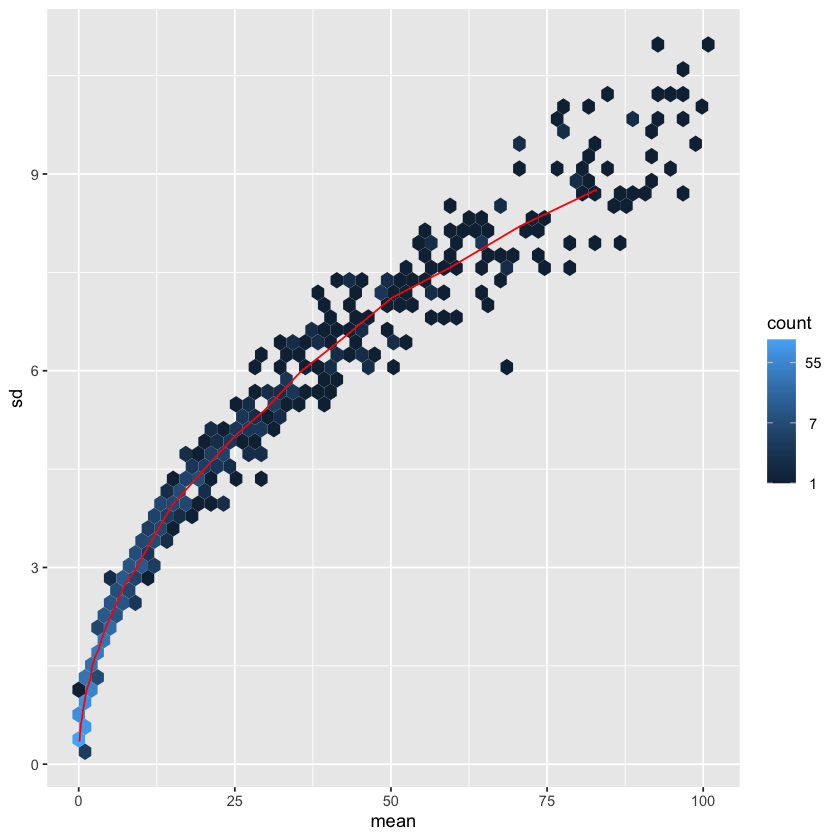

In [88]:
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)

library("vsn")

meanSdPlot(cts, ranks = FALSE)

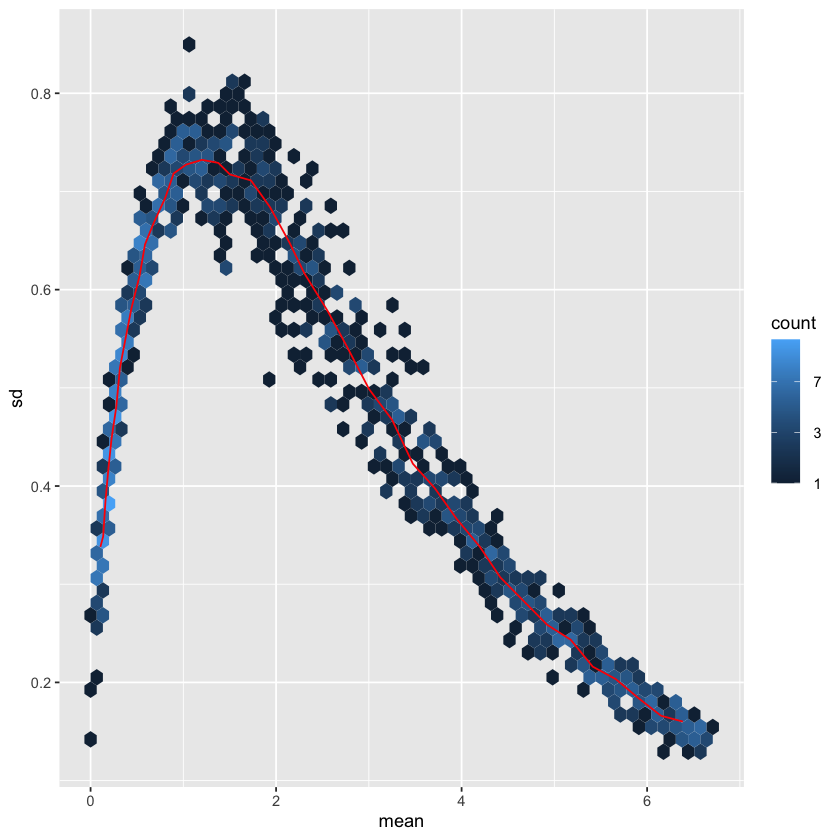

In [89]:
log.cts.one <- log2(cts + 1)
meanSdPlot(log.cts.one, ranks = FALSE)

The logarithm with a small pseudocount amplifies differences when the values are close to 0. The low count genes with low signal-to-noise ratio will overly contribute to sample-sample distances and PCA plots.

As a solution, DESeq2 offers two transformations for count data that stabilize the variance across the mean: the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber 2010), implemented in the vst function, and the regularized-logarithm transformation or rlog (Love, Huber, and Anders 2014).

For genes with high counts, both the VST and the rlog will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards a middle value. The VST or rlog-transformed data then become approximately homoskedastic (more flat trend in the meanSdPlot), and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data. <em>Which transformation to choose?</em> The VST is much faster to compute and is less sensitive to high count outliers than the rlog. The rlog tends to work well on small datasets (n < 30), potentially outperforming the VST when there is a wide range of sequencing depth across samples (an order of magnitude difference). We therefore recommend the VST for medium-to-large datasets (n > 30). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.



We first perform VST 

In [92]:
vsd <- vst(dds, blind = FALSE)

using 'avgTxLength' from assays(dds), correcting for library size



In [93]:
head(assay(vsd), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003.14,10.105781,9.852029,10.169726,9.991545,10.424865,10.194490,10.315814,10.002177
ENSG00000000005.5,7.755929,7.755929,7.755929,7.755929,7.755929,7.755929,7.755929,7.755929
ENSG00000000419.12,9.692244,9.923647,9.801921,9.798653,9.763455,9.874703,9.683211,9.845507


Now, the rlog

In [94]:
rld <- rlog(dds, blind = FALSE)

using 'avgTxLength' from assays(dds), correcting for library size



In [95]:
head(assay(rld), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003.14,9.482611,9.172174,9.558386,9.345990,9.851369,9.587607,9.727261,9.357866
ENSG00000000005.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419.12,8.860176,9.150207,9.000043,8.995902,8.951324,9.091082,8.848771,9.054388


In the above function calls, we specified blind = FALSE, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully unsupervised transformation, one can set blind = TRUE (which is the default).

To show the effect of the transformation, in the figure below we plot the first sample against the second, first simply using the log2 function (after adding 1, to avoid taking the log of zero), and then using the VST and rlog-transformed values. For the log2 approach, we need to first estimate size factors to account for sequencing depth, and then specify normalized=TRUE. Sequencing depth correction is done automatically for the vst and rlog.

In [96]:
library("dplyr")
library("ggplot2")

Warning message:
"package 'dplyr' was built under R version 3.6.2"

Attaching package: 'dplyr'


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:matrixStats':

    count


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning 

In [97]:
dds <- estimateSizeFactors(dds)

using 'avgTxLength' from assays(dds), correcting for library size



Warning message:
"`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


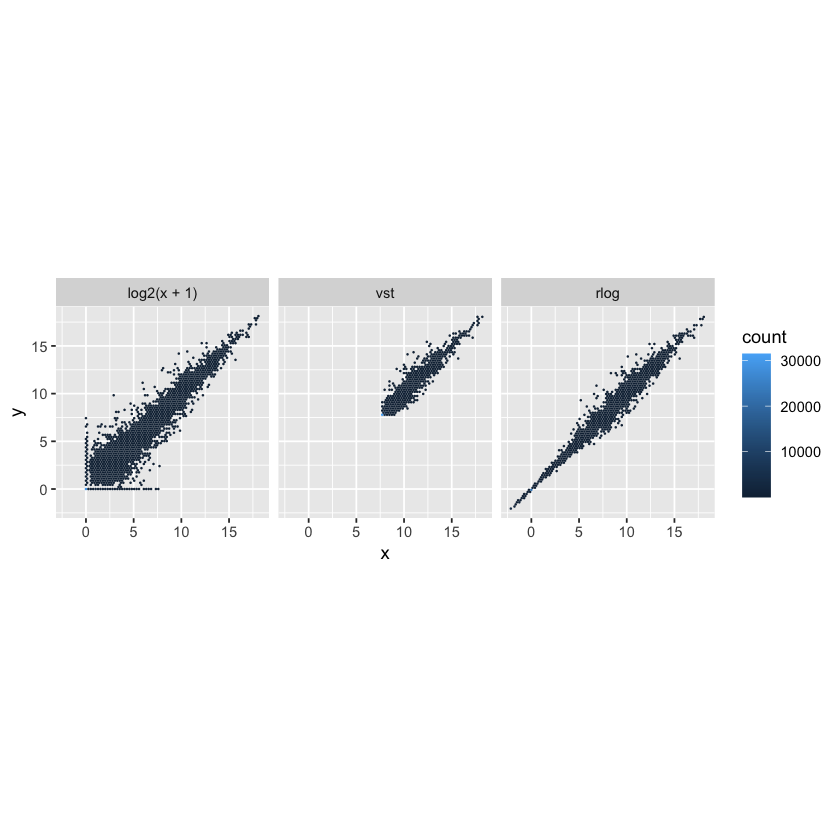

In [98]:
df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"))
  
colnames(df)[1:2] <- c("x", "y")  

lvls <- c("log2(x + 1)", "vst", "rlog")
df$transformation <- factor(df$transformation, levels=lvls)

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

Scatterplot of transformed counts from two samples. Shown are scatterplots using the log2 transform of normalized counts (left), using the VST (middle), and using the rlog (right). While the rlog is on roughly the same scale as the log2 counts, the VST has a upward shift for the smaller values. It is the differences between samples (deviation from y=x in these scatterplots) which will contribute to the distance calculations and the PCA plot.

We can see how genes with low counts (bottom left-hand corner) seem to be excessively variable on the ordinary logarithmic scale, while the VST and rlog compress differences for the low count genes for which the data provide little information about differential expression.




*****
[back to the top](#top)


<a href id="sampledistances"></a>


## Sample distances


A useful first step in an RNA-seq analysis is often to assess overall similarity between samples: Which samples are similar to each other, which are different? Does this fit to the expectation from the experiment’s design?

We use the R function dist to calculate the Euclidean distance between samples. To ensure we have a roughly equal contribution from all genes, we use it on the VST data. We need to transpose the matrix of values using t, because the dist function expects the different samples to be rows of its argument, and different dimensions (here, genes) to be columns.



In [99]:
sampleDists <- dist(t(assay(vsd)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   39.54414                                                       
SRR1039512   32.51782   45.05345                                            
SRR1039513   51.18143   37.32093   41.91328                                 
SRR1039516   35.72192   47.65381   34.97595   52.14227                      
SRR1039517   51.34895   41.70640   46.99966   40.78601   39.86182           
SRR1039520   32.52656   47.07044   30.52500   48.18564   37.20324   50.47938
SRR1039521   51.56618   37.69321   47.26451   31.58790   52.70269   41.45931
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   43.11495

In [100]:
library("pheatmap")
library("RColorBrewer")

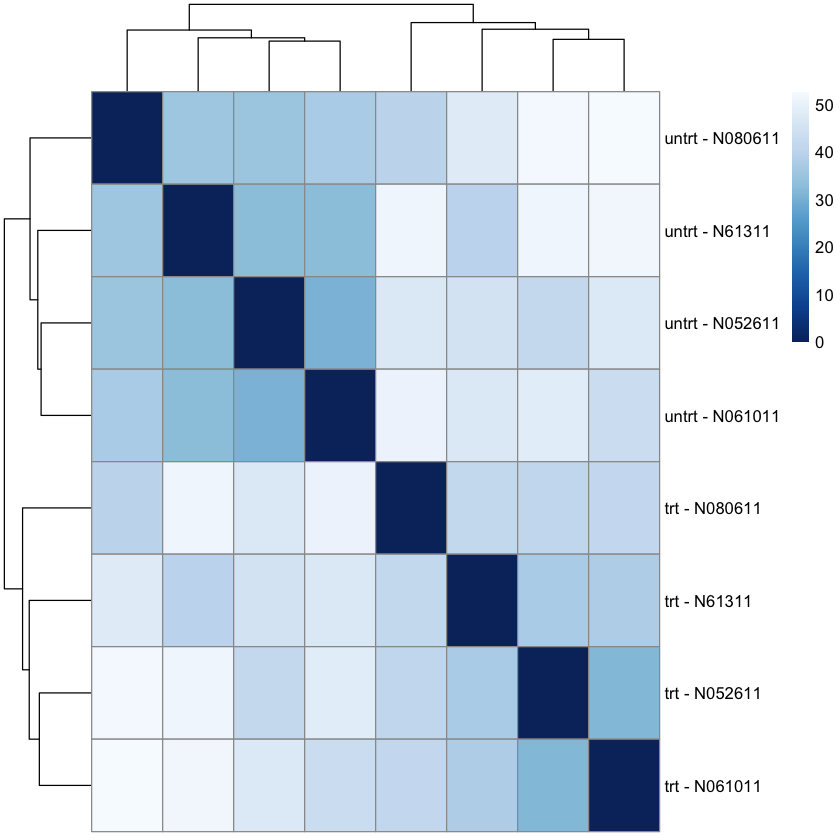

In [101]:
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( vsd$dex, vsd$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

### PCA plot

Another way to visualize sample-to-sample distances is a principal components analysis (PCA). In this ordination method, the data points (here, the samples) are projected onto the 2D plane such that they spread out in the two directions that explain most of the differences (figure below). The x-axis is the direction that separates the data points the most. The values of the samples in this direction are written PC1. The y-axis is a direction (it must be orthogonal to the first direction) that separates the data the second most. The values of the samples in this direction are written PC2. The percent of the total variance that is contained in the direction is printed in the axis label. Note that these percentages do not add to 100%, because there are more dimensions that contain the remaining variance (although each of these remaining dimensions will explain less than the two that we see).

In [102]:
# you can actually get the data
pcaData <- plotPCA(vsd, intgroup = c( "dex", "cell"), returnData = TRUE)
#pcaData

In [103]:
percentVar <- round(100 * attr(pcaData, "percentVar"))

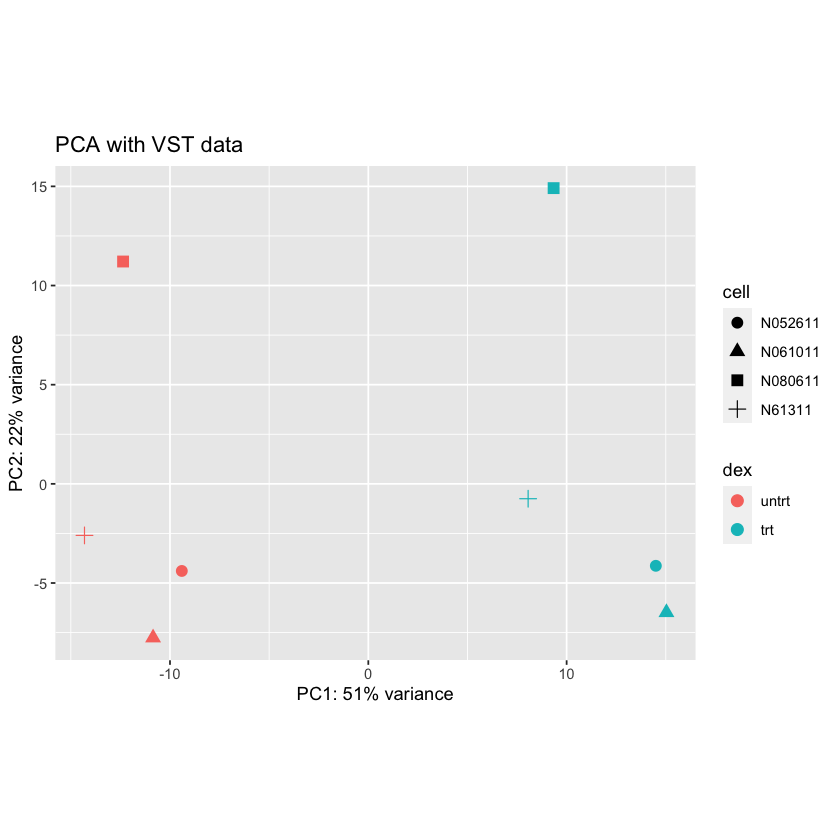

In [104]:
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  ggtitle("PCA with VST data")

### MDS plot

Another plot, very similar to the PCA plot, can be made using the multidimensional scaling (MDS) function in base R. This is useful when we don’t have a matrix of data, but only a matrix of distances. Here we compute the MDS for the distances calculated from the VST data and plot these in a figure below.

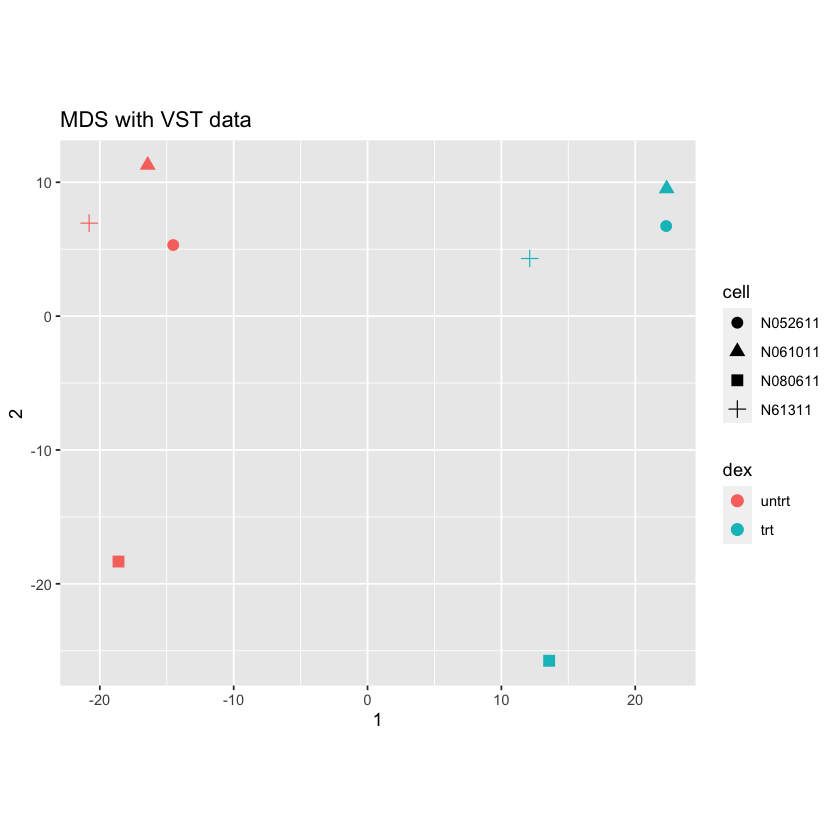

In [105]:
mds <- as.data.frame(colData(vsd))  %>%
         cbind(cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed() + ggtitle("MDS with VST data")




*****
[back to the top](#top)

<a href id="dea"></a>

## Differential expression analysis

As we have already specified an experimental design when we created the DESeqDataSet, we can run the differential expression pipeline on the raw counts with a single call to the function DESeq:

In [106]:
dds <- DESeq(dds)

using pre-existing normalization factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

Calling results without any arguments will extract the estimated log2 fold changes and p values for the last variable in the design formula. If there are more than 2 levels for this variable, results will extract the results table for a comparison of the last level over the first level. The comparison is printed at the top of the output: dex trt vs untrt.



In [107]:
res <- results(dds)
res

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 58294 rows and 6 columns
                            baseMean      log2FoldChange             lfcSE
                           <numeric>           <numeric>         <numeric>
ENSG00000000003.14  739.940717372053  -0.361153676671791 0.106868520698714
ENSG00000000005.5                  0                  NA                NA
ENSG00000000419.12   511.73572199559   0.206314742351884  0.12866446675691
ENSG00000000457.13  314.194855097564  0.0378307676321096 0.158633313724798
ENSG00000000460.16  79.7936215457165  -0.115259035980507 0.314990334978644
...                              ...                 ...               ...
ENSG00000285990.1  0.642314540619725   0.364733264633251  3.43327565299413
ENSG00000285991.1   11.2762841129775  -0.116551380982968 0.748600358091742
ENSG00000285992.1  0.104030399470675  -0.439471569336132  3.52281415159258
ENSG00000285993.1                  0                  NA

We could have equivalently produced this results table with the following more specific command. Because dex is the last variable in the design, we could optionally leave off the contrast argument to extract the comparison of the two levels of dex.

In [108]:
res <- results(dds, contrast=c("dex","trt","untrt"))

Description of 'res' object

In [111]:
mcols(res, use.names = TRUE)

DataFrame with 6 rows and 2 columns
                       type                               description
                <character>                               <character>
baseMean       intermediate mean of normalized counts for all samples
log2FoldChange      results  log2 fold change (MLE): dex trt vs untrt
lfcSE               results          standard error: dex trt vs untrt
stat                results          Wald statistic: dex trt vs untrt
pvalue              results       Wald test p-value: dex trt vs untrt
padj                results                      BH adjusted p-values

The first column, baseMean, is a just the average of the normalized count values, divided by the size factors, taken over all samples in the DESeqDataSet. The remaining four columns refer to a specific contrast, namely the comparison of the trt level over the untrt level for the factor variable dex. We will find out below how to obtain other contrasts.

The column log2FoldChange is the effect size estimate. It tells us how much the gene’s expression seems to have changed due to treatment with dexamethasone in comparison to untreated samples. This value is reported on a logarithmic scale to base 2: for example, a log2 fold change of 1.5 means that the gene’s expression is increased by a multiplicative factor of 21.5≈2.82 .

Of course, this estimate has an uncertainty associated with it, which is available in the column lfcSE, the standard error estimate for the log2 fold change estimate. We can also express the uncertainty of a particular effect size estimate as the result of a statistical test. The purpose of a test for differential expression is to test whether the data provides sufficient evidence to conclude that this value is really different from zero. DESeq2 performs for each gene a hypothesis test to see whether evidence is sufficient to decide against the null hypothesis that there is zero effect of the treatment on the gene and that the observed difference between treatment and control was merely caused by experimental variability (i.e., the type of variability that you can expect between different samples in the same treatment group). As usual in statistics, the result of this test is reported as a p value, and it is found in the column pvalue. Remember that a p value indicates the probability that a fold change as strong as the observed one, or even stronger, would be seen under the situation described by the null hypothesis.

We can also summarize the results with the following line of code, which reports some additional information, that will be covered in later sections.

In [112]:
summary(res)


out of 35573 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2373, 6.7%
LFC < 0 (down)     : 1948, 5.5%
outliers [1]       : 0, 0%
low counts [2]     : 18662, 52%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Results at specific p-value

In [114]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)



FALSE  TRUE 
13370  3541 

Other comparisons, using 'contrast'

In [115]:
results(dds, contrast = c("cell", "N061011", "N61311"))

log2 fold change (MLE): cell N061011 vs N61311 
Wald test p-value: cell N061011 vs N61311 
DataFrame with 58294 rows and 6 columns
                            baseMean      log2FoldChange             lfcSE
                           <numeric>           <numeric>         <numeric>
ENSG00000000003.14  739.940717372053    0.27094507355163 0.152170582542007
ENSG00000000005.5                  0                  NA                NA
ENSG00000000419.12   511.73572199559 -0.0718309511954792 0.182816614221926
ENSG00000000457.13  314.194855097564   0.179880572092945 0.225121892455565
ENSG00000000460.16  79.7936215457165  -0.119482055770136 0.441593347816702
...                              ...                 ...               ...
ENSG00000285990.1  0.642314540619725   -3.09564035666317  4.85271500898552
ENSG00000285991.1   11.2762841129775    -0.8779628135943  1.04696204913297
ENSG00000285992.1  0.104030399470675                   0   4.9975798104491
ENSG00000285993.1                  0        

#Multiple testing In high-throughput biology, we are careful to not use the p values directly as evidence against the null, but to correct for multiple testing. What would happen if we were to simply threshold the p values at a low value, say 0.05? There are 5170 genes with a p value below 0.05 among the 31604 genes for which the test succeeded in reporting a p value:

In [116]:
sum(res$pvalue < 0.05, na.rm=TRUE)

[1] 5170

In [117]:
sum(!is.na(res$pvalue))

[1] 35573

Now, assume for a moment that the null hypothesis is true for all genes, i.e., no gene is affected by the treatment with dexamethasone. Then, by the definition of the p value, we expect up to 5% of the genes to have a p value below 0.05. This amounts to 1580 genes. If we just considered the list of genes with a p value below 0.05 as differentially expressed, this list should therefore be expected to contain up to 1580 / 5170 = 31% false positives.

DESeq2 uses the Benjamini-Hochberg (BH) adjustment (Benjamini and Hochberg 1995) as implemented in the base R p.adjust function; in brief, this method calculates for each gene an adjusted p value that answers the following question: if one called significant all genes with an adjusted p value less than or equal to this gene’s adjusted p value threshold, what would be the fraction of false positives (the false discovery rate, FDR) among them, in the sense of the calculation outlined above? These values, called the BH-adjusted p values, are given in the column padj of the res object.

The FDR is a useful statistic for many high-throughput experiments, as we are often interested in reporting or focusing on a set of interesting genes, and we would like to put an upper bound on the percent of false positives in this set.

Hence, if we consider a fraction of 10% false positives acceptable, we can consider all genes with an adjusted p value below 10% = 0.1 as significant. How many such genes are there?



In [118]:
sum(res$padj < 0.1, na.rm=TRUE)

[1] 4321

We subset the results table to these genes and then sort it by the log2 fold change estimate to get the significant genes with the strongest down-regulation:

In [119]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                          baseMean    log2FoldChange             lfcSE
                         <numeric>         <numeric>         <numeric>
ENSG00000216490.3 42.3007106248874 -5.72482604043858  1.47565155349927
ENSG00000267339.5 30.5206063861615 -5.39781082595533 0.773016396308886
ENSG00000257542.5 10.0398869404764 -5.25991340821985  1.28200042234165
ENSG00000146006.7 61.6448430808005 -4.49504163962542  0.66382064872257
ENSG00000108700.4 14.6323552674909 -4.09068685909494 0.941841582533616
ENSG00000213240.8  12.096158074824 -3.87312453832938  1.27413219583442
                               stat               pvalue                 padj
                          <numeric>            <numeric>            <numeric>
ENSG00000216490.3 -3.87952428665362 0.000104660951388532 0.000988603182197743
ENSG00000267339.5 -6.98278956530496 2.89375703333603e-12 9.46544007557941e-11
ENSG0



*****
[back to the top](#top)

<a href id="plotting"></a>

## Plotting results


Counts plot

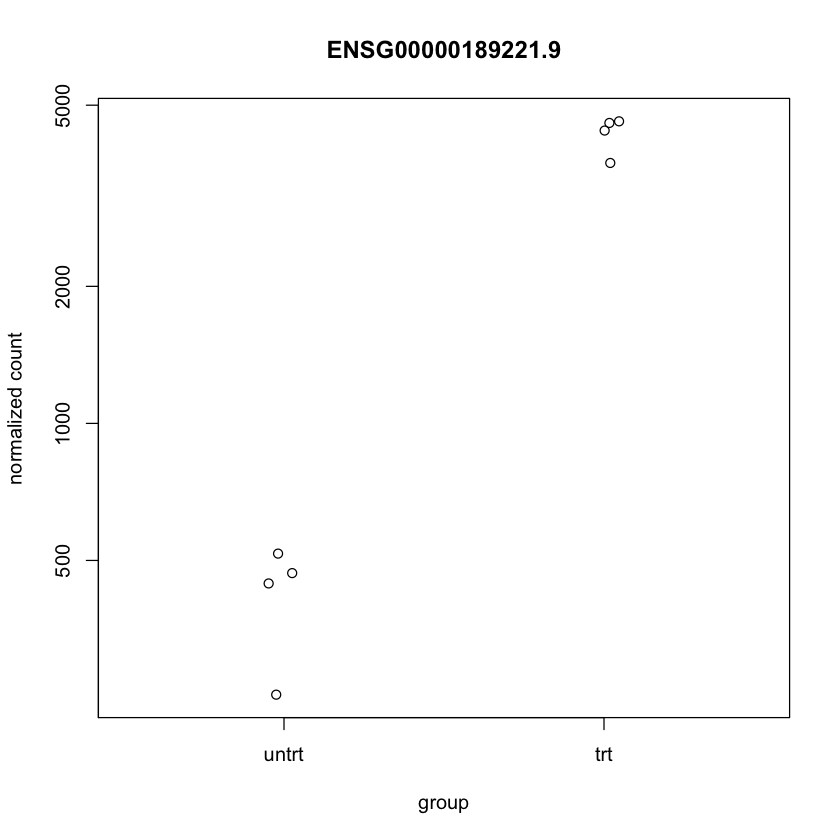

In [120]:
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = topGene, intgroup=c("dex"))

Normalized counts for a single gene over treatment group.

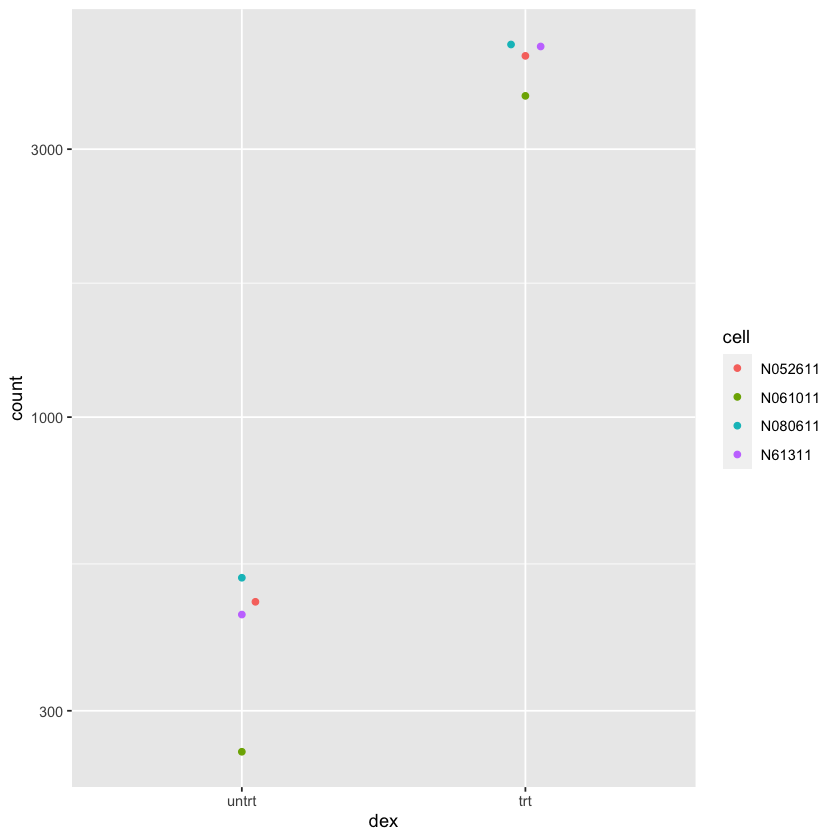

In [121]:
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = topGene, intgroup = c("dex","cell"),
                         returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) +
  scale_y_log10() +  geom_beeswarm(cex = 3)

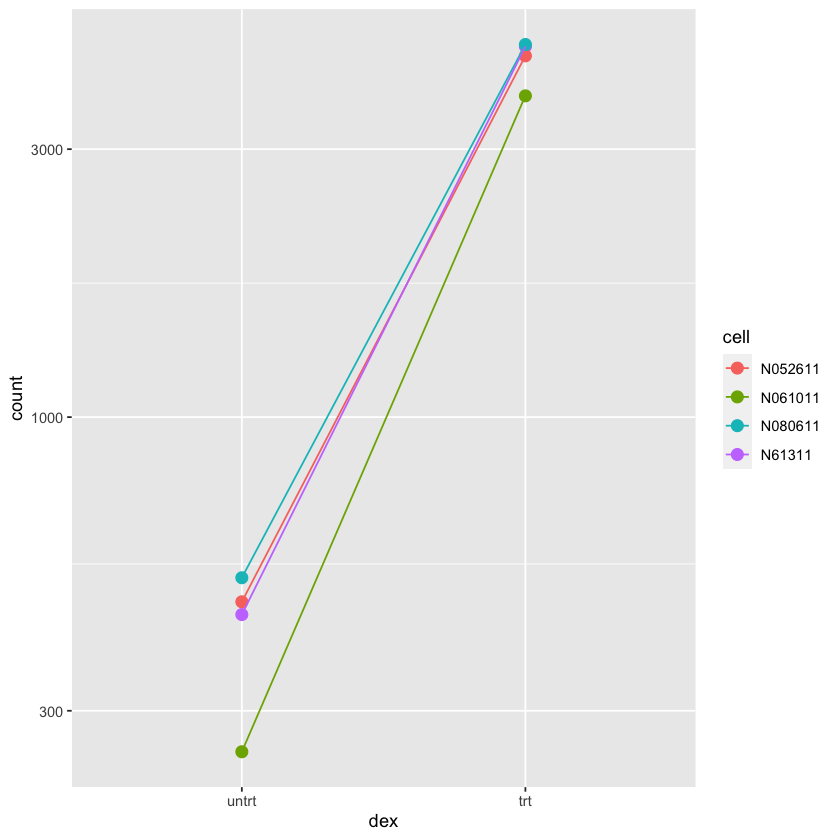

In [122]:
ggplot(geneCounts, aes(x = dex, y = count, color = cell, group = cell)) +
  scale_y_log10() + geom_point(size = 3) + geom_line()

### The MA plot

An MA-plot (Dudoit et al. 2002) provides a useful overview for the distribution of the estimated coefficients in the model, e.g. the comparisons of interest, across all genes. On the y-axis, the “M” stands for “minus” – subtraction of log values is equivalent to the log of the ratio – and on the x-axis, the “A” stands for “average”. You may hear this plot also referred to as a mean-difference plot, or a Bland-Altman plot.

Before making the MA-plot, we use the lfcShrink function to shrink the log2 fold changes for the comparison of dex treated vs untreated samples. There are three types of shrinkage estimators in DESeq2, which are covered in the DESeq2 vignette. Here we specify the apeglm method for shrinking coefficients, which is good for shrinking the noisy LFC estimates while giving low bias LFC estimates for true large differences (Zhu, Ibrahim, and Love 2018). To use apeglm we specify a coefficient from the model to shrink, either by name or number as the coefficient appears in resultsNames(dds).



In [123]:
library("apeglm")
resultsNames(dds)

[1] "Intercept"               "cell_N061011_vs_N052611"
[3] "cell_N080611_vs_N052611" "cell_N61311_vs_N052611" 
[5] "dex_trt_vs_untrt"

In [124]:
res <- lfcShrink(dds, coef="dex_trt_vs_untrt", type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



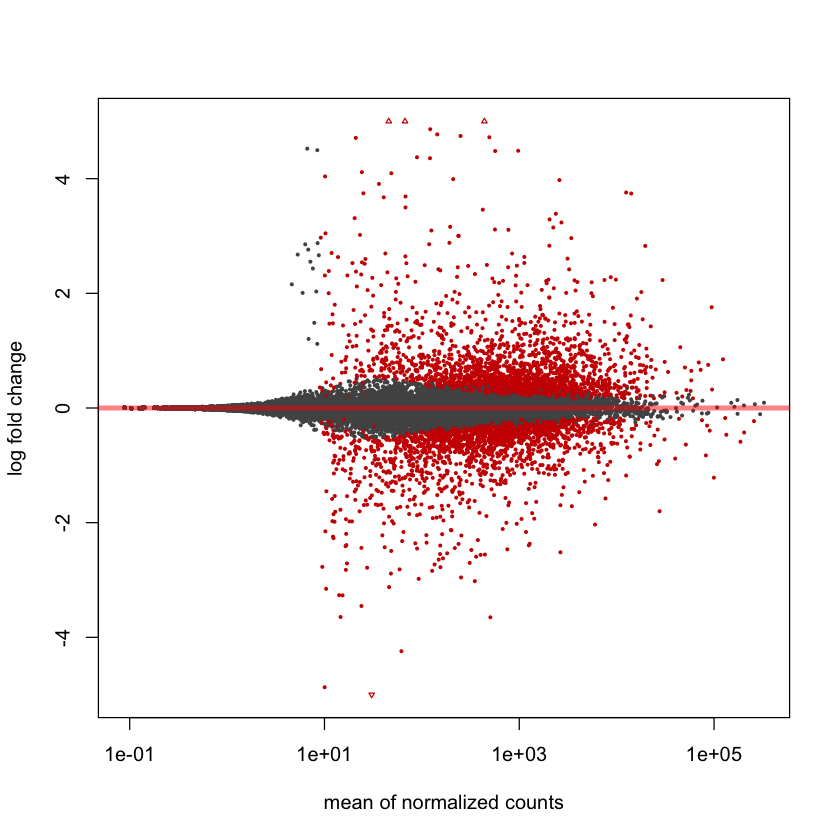

In [125]:
plotMA(res, ylim = c(-5, 5))

An MA-plot of changes induced by treatment. The log2 fold change for a particular comparison is plotted on the y-axis and the average of the counts normalized by size factor is shown on the x-axis. Each gene is represented with a dot. Genes with an adjusted p value below a threshold (here 0.1, the default) are shown in red.

The DESeq2 package uses a Bayesian procedure to moderate (or “shrink”) log2 fold changes from genes with very low counts and highly variable counts, as can be seen by the narrowing of the vertical spread of points on the left side of the MA-plot. As shown above, the lfcShrink function performs this operation. For a detailed explanation of the rationale of moderated fold changes, please see the DESeq2 paper (Love, Huber, and Anders 2014).

If we had not used statistical moderation to shrink the noisy log2 fold changes, we would have instead seen the following plot:

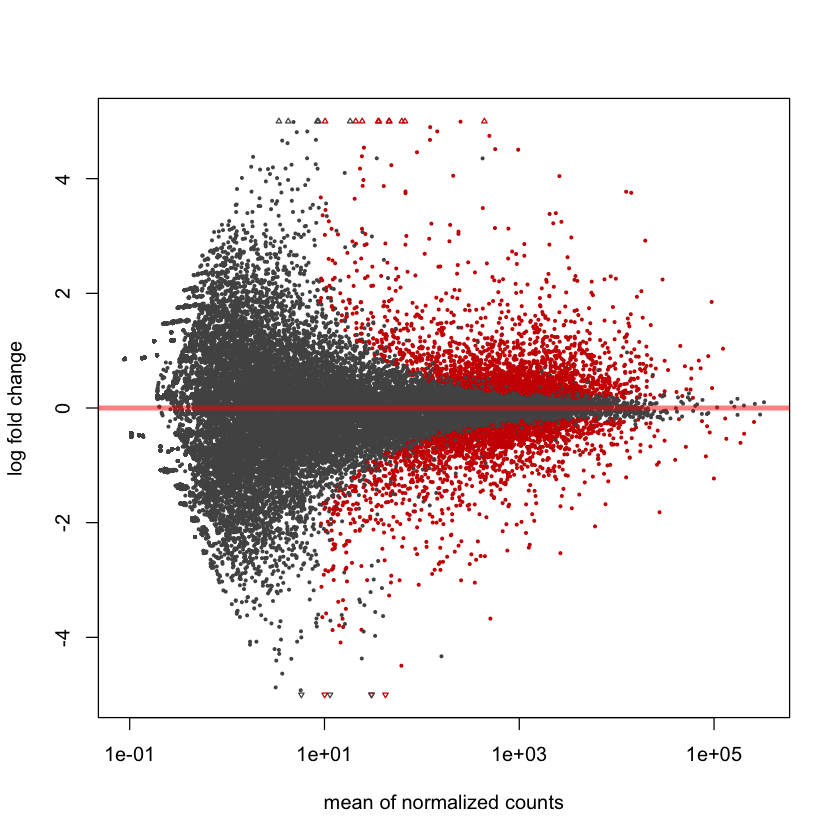

In [126]:
res.noshr <- results(dds, name="dex_trt_vs_untrt")
plotMA(res.noshr, ylim = c(-5, 5))

We can label individual points on the MA-plot as well. Here we use the with R function to plot a circle and text for a selected row of the results object. Within the with function, only the baseMean and log2FoldChange values for the selected rows of res are used.

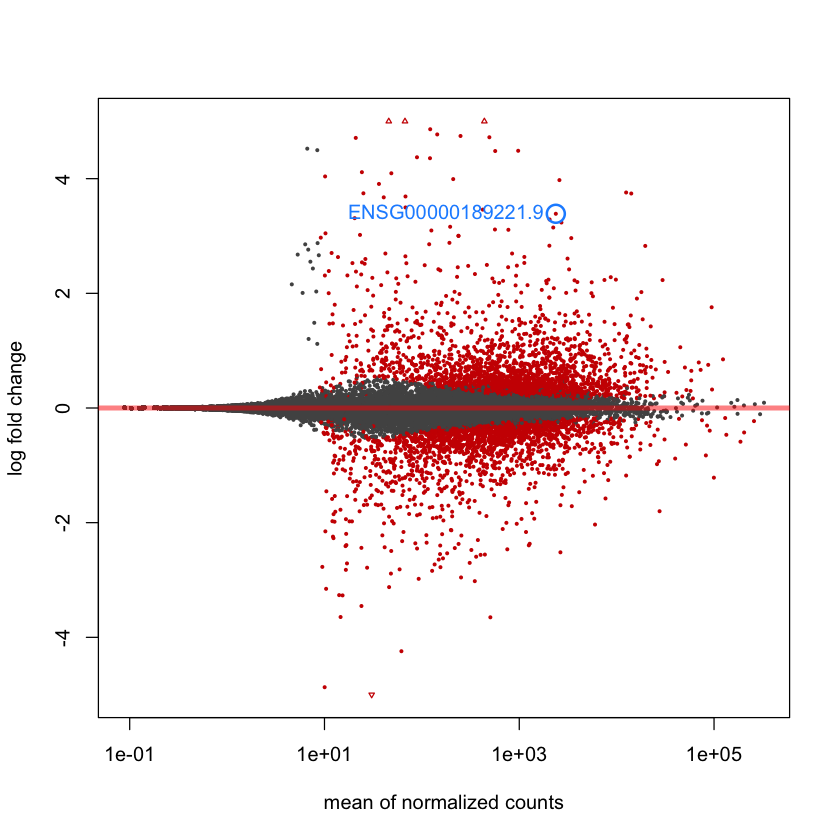

In [127]:
plotMA(res, ylim = c(-5,5))
topGene <- rownames(res)[which.min(res$padj)]
with(res[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})

Another useful diagnostic plot is the histogram of the p values (figure below). This plot is best formed by excluding genes with very small counts, which otherwise generate spikes in the histogram.

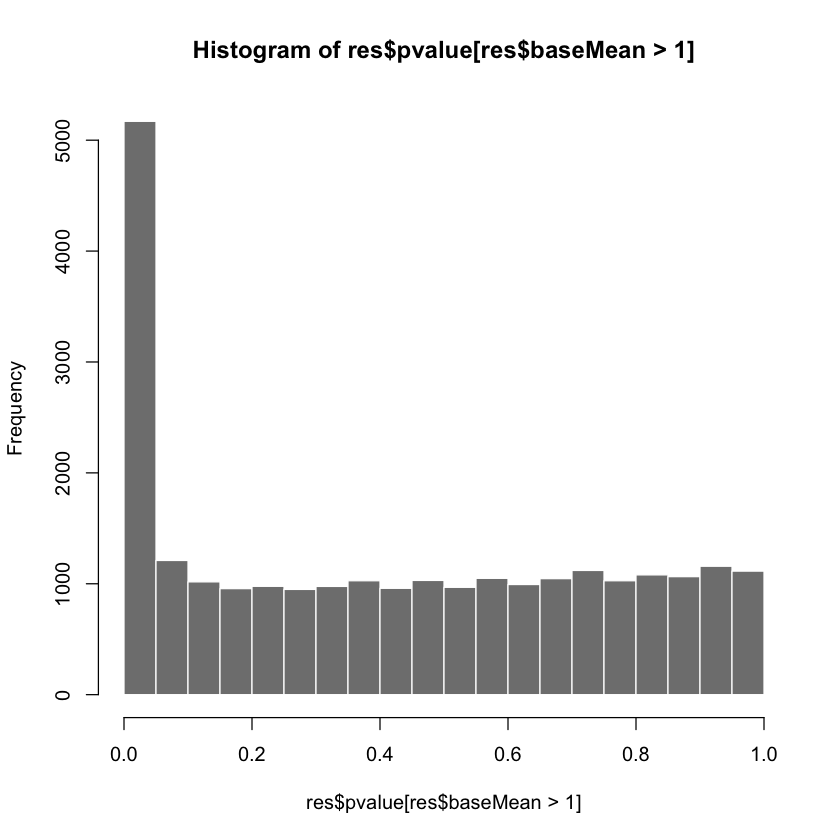

In [128]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")


*****
[back to the top](#top)


<a href id="clustering"></a>

## Gene clustering


In the sample distance heatmap made previously, the dendrogram at the side shows us a hierarchical clustering of the samples. Such a clustering can also be performed for the genes. Since the clustering is only relevant for genes that actually carry a signal, one usually would only cluster a subset of the most highly variable genes. Here, for demonstration, let us select the 20 genes with the highest variance across samples. We will work with the VST data.

In [129]:
library("genefilter")


Attaching package: 'genefilter'


The following objects are masked from 'package:matrixStats':

    rowSds, rowVars




In [130]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 20)

The heatmap becomes more interesting if we do not look at absolute expression strength but rather at the amount by which each gene deviates in a specific sample from the gene’s average across all samples. Hence, we center each genes’ values across samples, and plot a heatmap (figure below). We provide a data.frame that instructs the pheatmap function how to label the columns.



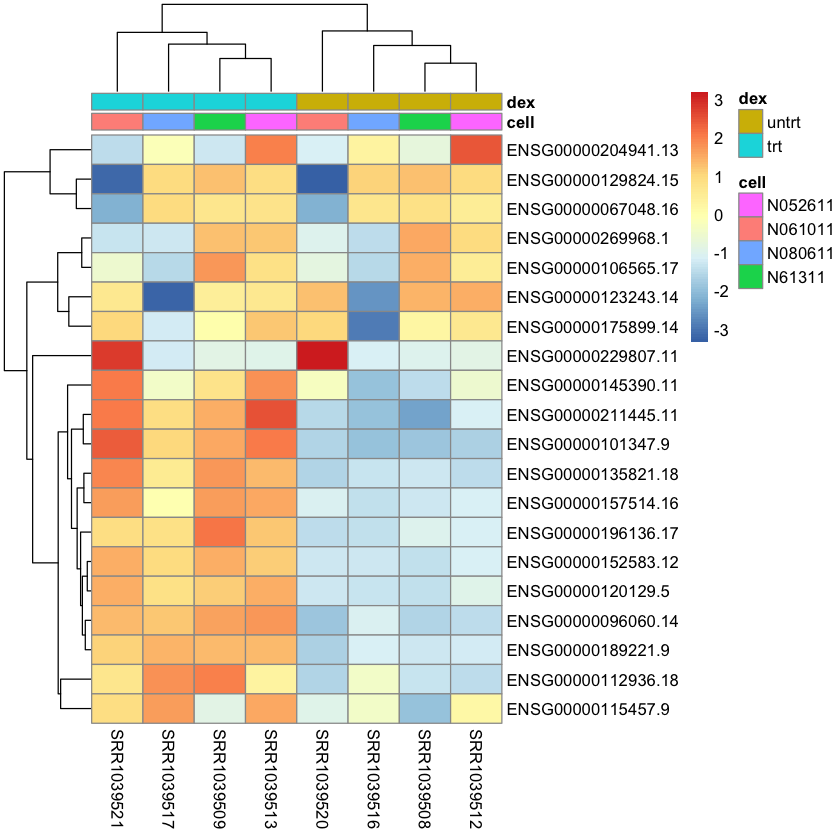

In [131]:
mat  <- assay(vsd)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(vsd)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)



*****
[back to the top](#top)

<a href id="results"></a>

## Annotating and exporting results

Our result table so far only contains the Ensembl gene IDs, but alternative gene names may be more informative for interpretation. Bioconductor’s annotation packages help with mapping various ID schemes to each other. We load the AnnotationDbi package and the annotation package org.Hs.eg.db:

Further downstream analysis can be performed, e.g. gene and pathway enrichment analysis etc.

*****
[back to the top](#top)

<a id="yourturn"></a>
## Your Turn


<div class="alert alert-block alert-info">
    <b>Task 1</b><br/>
   <p>Plot normalized counts for top 2 genes and bottom 2 genes over treatment group.</p> 
</div>

<div class="alert alert-block alert-info">
        <b>Task2</b></br>
<p>Create a bar chart showing top 100 and bottom 100 (based on FDR) genes in treatment groups</p>
</div>

*****
[back to the top](#top)

### Notebook details
<br>
<i>Notebook created by <strong>Mudassar Iqbal</strong>. Other contributors include Fran Hooley... 

Publish date: Nov. 2021<br>
Review date: July 2022</i>

Please give your feedback using the button below:

****

## Your Notes:
